# **CS376 Final project-Titanic's Surviver**

**Introduction**

Do you know about the sinking of the Titanic? This accident, which was made into a movie and attracted great attention, is still recorded as the world's largest maritime accident. After this accident, a number of new preventive measures against marine accidents were established, and at the time, the socially weak, such as women and children, were given priority to evacuate, drawing attention.

Of course, many things have changed between then and now, but nonetheless, the insight in maritime accidents that the Titanic accident gives is still maintained. I will analyze this data to build a model that predicts survivors of similar accidents. In addition, I will analyze which factors affect survival through weights assigned to each feature.

**Import libraries**

First, I imported all the libraries that will be used in the assignment. The libraries to be used in this assignment are as follows.

In [1]:
from google.colab import drive
import pandas as pd

import plotly.graph_objects as go

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import math

from plotly.subplots import make_subplots

import seaborn as sns

from scipy.stats.mstats import winsorize

from sklearn.feature_selection import chi2, SelectKBest

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

import plotly.express as px
import plotly.io as pio

**Load Data**

The data of the Titanic accident used the dataset provided by kaggle. I downloaded the data from Kaggle and put it on my gdrive. I will use the data by linking colab with gdrive.  The link to the data source is below:

data source: https://www.kaggle.com/competitions/titanic/overview

In [2]:
drive.mount('/content/drive')

filename = '/content/drive/My Drive/Colab Notebooks/기계학습/train.csv'
train_df = pd.read_csv(filename)

filename = '/content/drive/My Drive/Colab Notebooks/기계학습/test.csv'
test_df = pd.read_csv(filename)

Mounted at /content/drive


**EDA**

Before building the model, we will analyze the features contained in the data. We will analyze each feature to gain insight into the relationship between the feature and survival rate, and create a more suitable model.

First, we checked the amount of train and test datasets. The train dataset and test dataset have 891 and 418 data, respectively. This is a ratio of about 7:3.

In [308]:
train_shape=train_df.shape
test_shape=test_df.shape

labels=['Train Dataset', 'Test Dataset']
values=[train_shape[0], test_shape[0]]
print('[train, test]:', values)

fig=go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title_text='Dataset Shapes')
fig.show()

[train, test]: [891, 418]


Next, we checked the survival rate in the train dataset. As shown in the results below, the ratio of dead to survivors is observed to be about 6:4. Since the data is not extremely skewed, it was judged that the probability of the predicted value being relatively accurate is high.


In [8]:
survival=0
death=0
for survive in train_df['Survived']:
  if survive==1:
    survival+=1
  else:
    death+=1

labels=['Survive', 'Die']
values=[survival, death]

fig=go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title_text='survival rate')
fig.show()

Now let's look at each feature. According to the information provided by kaggle, there are a total of 12 features.
PassengerId means a number given randomly to classify each passenger.
Survived means survival, given as 1 if alive and 0 if not alive.
Ticket means the level of the purchased ticket.
Sex and Age literally mean sex and age.
Sibsp means the number of accompanying brothers or wives, and Parch means the 
number of accompanying parents or children.
Ticket means the number of the purchased ticket.
Fare means passenger fare.
Cabin means the number of the cabin.
Embarked means the name of the port you boarded.

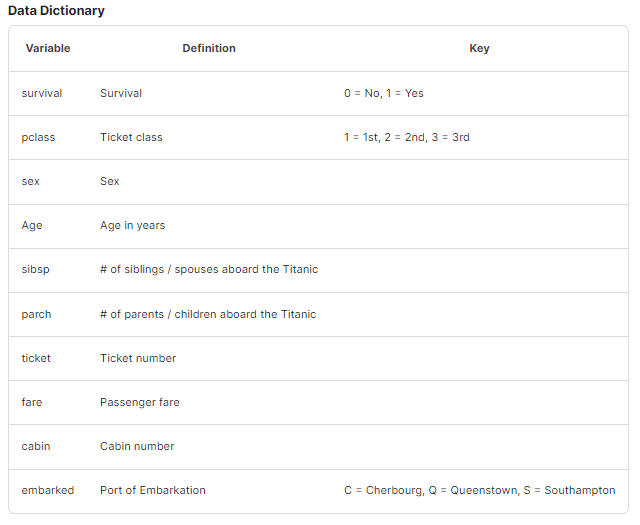

Through the info() function, data type and null of each feature were checked.

As a result of the analysis, it was confirmed that the three features of Cabin, Age, and Embarked contained null values. In the case of Pare, there is no problem in the trainset, but a null value appears in the testset. In particular, in the case of Cabin, it was confirmed that more than half of the values were filled with nulls.

In the case of type, it was confirmed that Name, Sex, Ticket, Cabin, and Embarked were text types and the rest were numeric types.

In [9]:
print("Summary of Train Dataset:")
print(train_df.info())

print("\nSummary of Test Dataset:")
print(test_df.info())

Summary of Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Summary of Test Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  ----- 

Prior to full-scale analysis, meaningless features are removed. In the case of PassengerId, it is a number given randomly to identify passengers, so it is removed. As a same result, I remove Name too.

If the null value is more than 1/4 of the total value, the corresponding feature is not helpful for learning, so it was deleted. If the null value is less than 1/4 of the total value, null is replaced with the most frequent value to minimize the effect on learning.

In [3]:
drop=['PassengerId', 'Name']
for col in train_df.columns:
  if train_df[col].isna().sum()>len(train_df)/4:
    drop.append(col)
  elif train_df[col].isna().sum()>0:
    train_df[col]=train_df[col].fillna(train_df[col].mode()[0])
train_df.drop(columns=drop, axis=1, inplace=True)
print("remove:", drop)
train_df.head()

remove: ['PassengerId', 'Name', 'Cabin']


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,female,35.0,1,0,113803,53.1000,S
4,0,3,male,35.0,0,0,373450,8.0500,S


Lastly, in case of an unexpected situation, check if there are duplicate keys and move on to the next step.

In [14]:
print("Duplicate values in train_df: ", train_df.duplicated().sum())
print("Duplicate values in test_df: ", test_df.duplicated().sum())

Duplicate values in train_df:  0
Duplicate values in test_df:  0


**EDA**

Now, let's start the serious analysis. We calculated the maximum and minimum values, mean and variance of each feature as follows. It can be seen that the variance is measured very small for most features except for a few such as Fare. This indicates that there is a tendency for the values to appear concentrated at a specific value rather than spread evenly.

In [38]:
print("\033[1mtrain_df dataset analysis:\033[0m")
print(train_df.agg(['min', 'max', 'mean', 'var']))

train_df dataset analysis:
      Survived    Pclass     Sex         Age     SibSp     Parch     Ticket  \
min   0.000000  1.000000  female    0.420000  0.000000  0.000000     110152   
max   1.000000  3.000000    male   80.000000  8.000000  6.000000  WE/P 5735   
mean  0.383838  2.308642     NaN   28.566970  0.523008  0.381594        NaN   
var   0.236772  0.699015     NaN  174.228695  1.216043  0.649728        NaN   

             Fare Embarked  
min      0.000000        C  
max    512.329200        S  
mean    32.204208      NaN  
var   2469.436846      NaN  


<ipython-input-38-bf00b7d715f5>:2: FutureWarning: ['Sex', 'Ticket', 'Embarked'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(train_df.agg(['min', 'max', 'mean', 'var']))


For more robust analysis, we created a graph for correlationship between survival and each feature. A linear graph was used for numerical features such as Pclass and Age, and a bar graph was used for categorical features such as Name and Ticket.

In [4]:
categorical=['Survived', 'Sex', 'Ticket', 'Embarked']
numerical=[numerical for numerical in train_df.columns if numerical not in categorical]
print(categorical, numerical)

['Survived', 'Sex', 'Ticket', 'Embarked'] ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


max-mode: 49


<ipython-input-53-421c1aee6070>:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print("max-mode:", max(num_survival)-stats.mode(num_survival)[0][0])


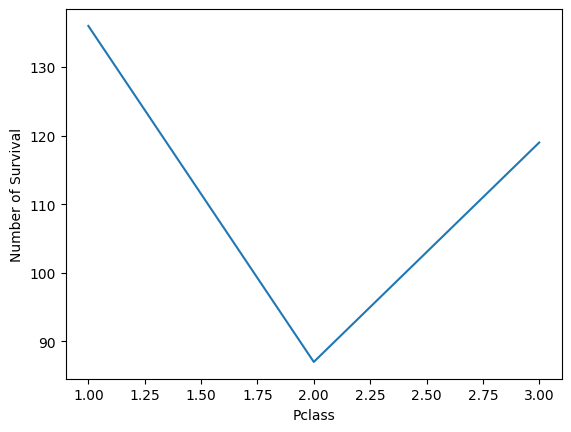

max-mode: 124


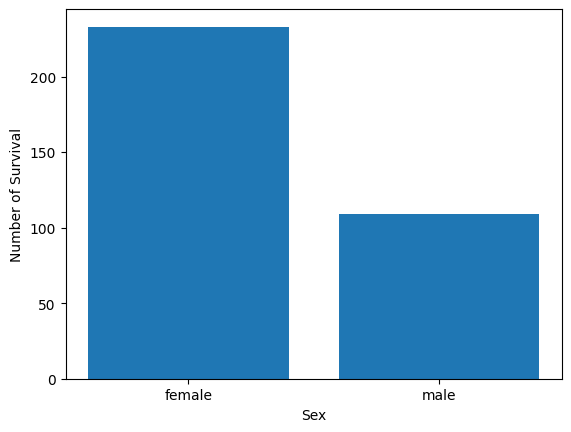

max-mode: 67


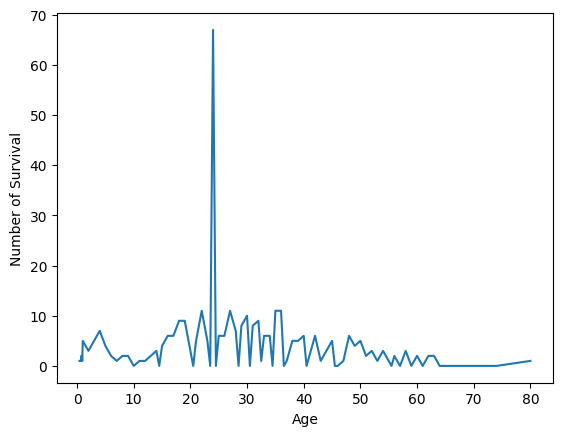

max-mode: 210


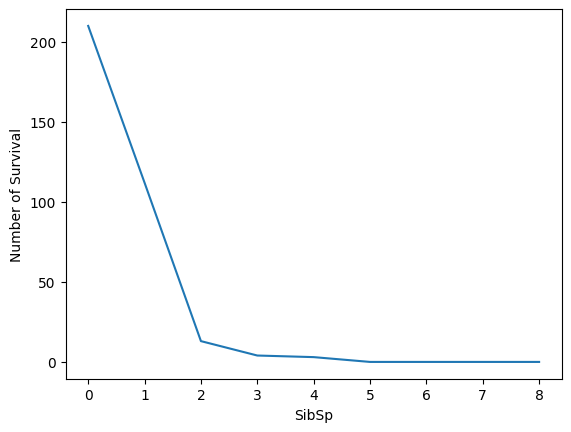

max-mode: 233


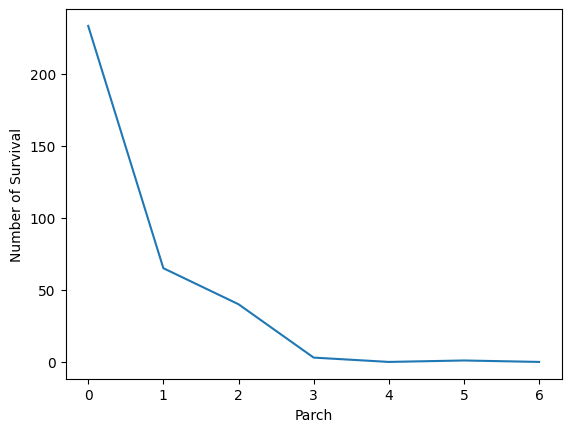

max-mode: 5


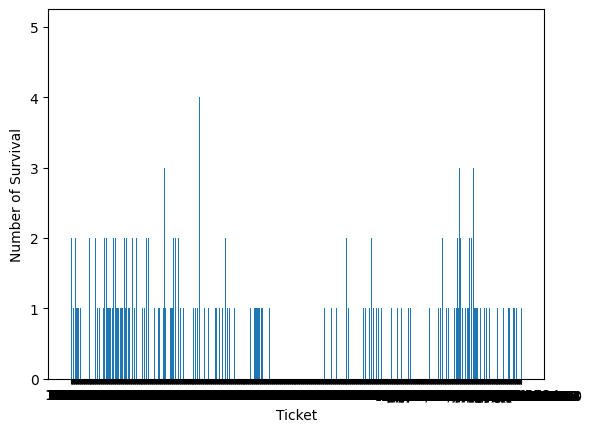

max-mode: 16


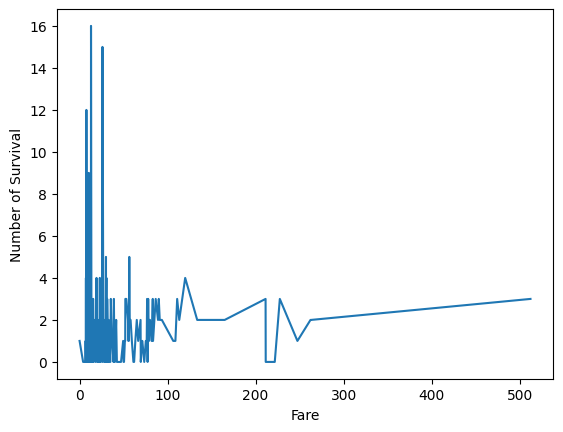

max-mode: 189


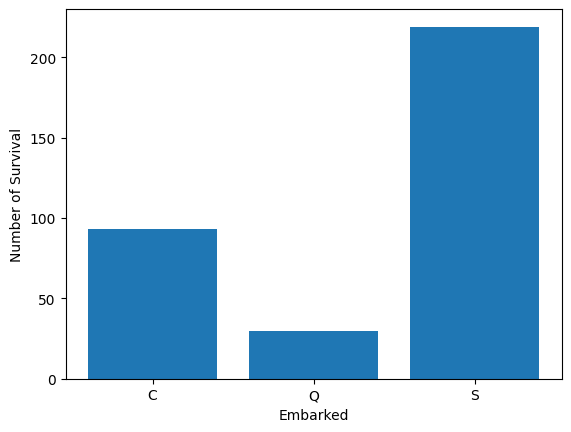

In [53]:
for col in list(train_df.drop(columns='Survived', axis=1).columns):
  ordered=train_df.sort_values(by=col, ignore_index=True)
  x=[ordered[col][0]]
  num_survival=[ordered['Survived'][0]]

  for j in range(len(ordered['Survived'])-1): #count # of survival
    if ordered[col][j]!=ordered[col][j+1]:
      x.append(ordered[col][j+1])
      num_survival.append(0)
    if ordered['Survived'][j+1]==1:
      num_survival[-1]+=1

  print("max-mode:", max(num_survival)-stats.mode(num_survival)[0][0])

  if col in categorical:
    for i in range(len(x)):
      x[i]=str(x[i])
    plt.bar(x, num_survival)
    plt.xlabel(col)
    plt.ylabel('Number of Survival')
    plt.show()

  else:
    plt.plot(x, num_survival)
    plt.xlabel(col)
    plt.ylabel('Number of Survival')
    plt.show()

**Data Preprocessing**

To check whether there was a significant change depending on the type of feature, the degree of concentration of survival values was evaluated by subtracting the mode value from the highest survival number. As a result, the ticket showed a difference of 5 and was evenly distributed on the graph, so it was excluded from the feature.

In the case of Pclass, there are only 3 values, and the survival value decreases only in clss 2. Therefore, it was evaluated that evaluating with a categorical value rather than a numerical value would help to obtain a more accurate prediction.

In [5]:
categorical.remove('Ticket')
train_df.drop(columns='Ticket', axis=1, inplace=True)

categorical.append('Pclass')
numerical.remove('Pclass')

print(categorical, numerical)

['Survived', 'Sex', 'Embarked', 'Pclass'] ['Age', 'SibSp', 'Parch', 'Fare']


Looking at the graph above, we can see that the survival rate for Age is concentrated in infants and young adults. It is very difficult to find a linear relationship in this type of graph. Therefore, it will be divided into 10-year-old units and treated as categorical values.

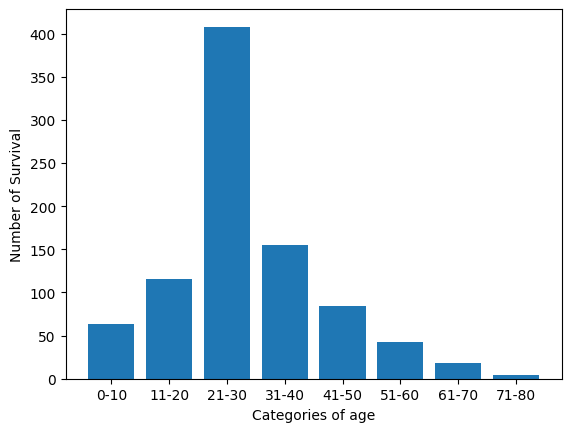

,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80
0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0


In [6]:
def categorical_age(train_df):
  data={
      '0-10': [0 for i in range(len(train_df))],
      '11-20': [0 for i in range(len(train_df))],
      '21-30': [0 for i in range(len(train_df))],
      '31-40': [0 for i in range(len(train_df))],
      '41-50': [0 for i in range(len(train_df))],
      '51-60': [0 for i in range(len(train_df))],
      '61-70': [0 for i in range(len(train_df))],
      '71-80': [0 for i in range(len(train_df))]
  }
  df=pd.DataFrame(data)

  for r in range(len(train_df)):
    if train_df.loc[r, 'Age']<11:
      df.loc[r, '0-10']=1
    elif train_df.loc[r, 'Age']<21:
      df.loc[r, '11-20']=1
    elif train_df.loc[r, 'Age']<31:
      df.loc[r, '21-30']=1
    elif train_df.loc[r, 'Age']<41:
      df.loc[r, '31-40']=1
    elif train_df.loc[r, 'Age']<51:
      df.loc[r, '41-50']=1
    elif train_df.loc[r, 'Age']<61:
      df.loc[r, '51-60']=1
    elif train_df.loc[r, 'Age']<71:
      df.loc[r, '61-70']=1
    else:
      df.loc[r, '71-80']=1

  return df

df=categorical_age(train_df)

age_cat=[sum(df['0-10']), sum(df['11-20']), sum(df['21-30']), sum(df['31-40']), sum(df['41-50']), sum(df['51-60']), sum(df['61-70']), sum(df['71-80'])]

plt.bar(df.columns, age_cat)
plt.xlabel('Categories of age')
plt.ylabel('Number of Survival')
plt.show()

df.head()

In [7]:
numerical.remove('Age')
train_df.drop(columns='Age', axis=1, inplace=True)

df.drop(columns='0-10', axis=1, inplace=True) #drop_first
categorical.extend(df.columns)
train_df=pd.concat([train_df, df], axis=1)

print(categorical, numerical)
train_df.head()

['Survived', 'Sex', 'Embarked', 'Pclass', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80'] ['SibSp', 'Parch', 'Fare']


,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,11-20,21-30,31-40,41-50,51-60,61-70,71-80
0,0,3,male,1,0,7.2500,S,0,1,0,0,0,0,0
1,1,1,female,1,0,71.2833,C,0,0,1,0,0,0,0
2,1,3,female,0,0,7.9250,S,0,1,0,0,0,0,0
3,1,1,female,1,0,53.1000,S,0,0,1,0,0,0,0
4,0,3,male,0,0,8.0500,S,0,0,1,0,0,0,0


Next, a log scale was assigned to the numerical value. Looking at the graph, the numerical value is in the form of an exponential function with values on the left. In order to improve the performance of the model, the input value is logarithmic and processed into a form closer to linearity. In addition, max_value/logistic_max_value is multiplied to rescale to be close to normal distribution.

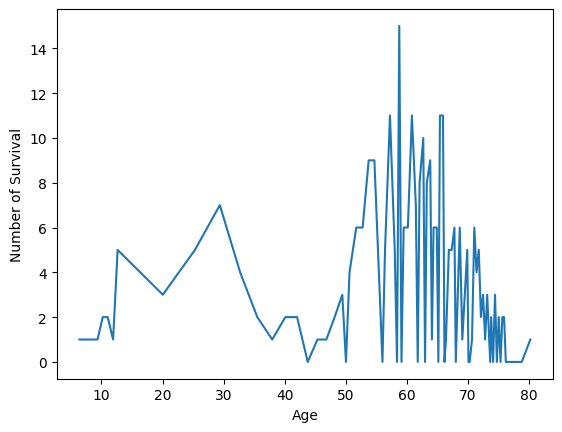

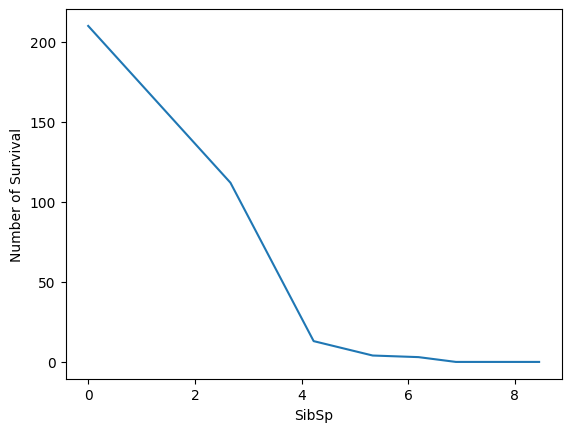

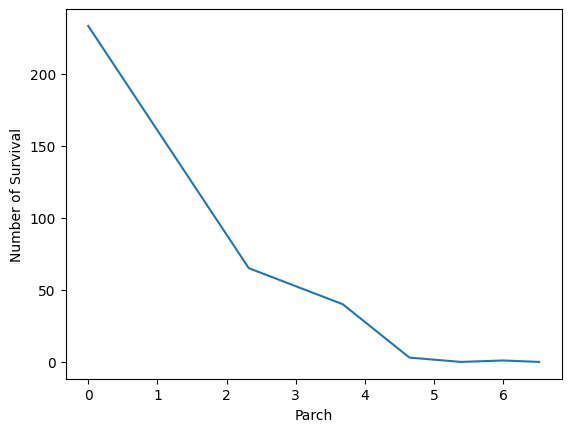

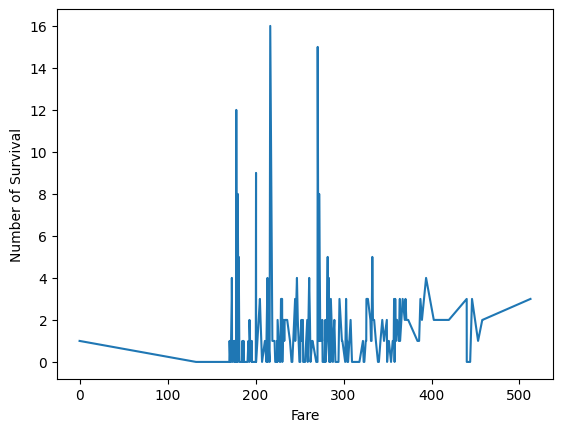

In [19]:
for col in  numerical:
  ordered=train_df.sort_values(by=col, ignore_index=True)
  x=[ordered[col][0]]
  num_survival=[ordered['Survived'][0]]

  for j in range(len(ordered['Survived'])-1): #count # of survival
    if ordered[col][j]!=ordered[col][j+1]:
      x.append(ordered[col][j+1])
      num_survival.append(0)
    if ordered['Survived'][j+1]==1:
      num_survival[-1]+=1

  for i in range(len(x)):
    x[i]=math.log(x[i]+1.0)/math.log(max(x))*max(x)

  train_df(col)

  plt.plot(x, num_survival)
  plt.xlabel(col)
  plt.ylabel('Number of Survival')
  plt.show()

In [275]:
'''
for col in numerical:
  train_df[col]=np.log(train_df[col]+1)/math.log(max(train_df[col]))*max(train_df[col])
train_df.head()
'''

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,11-20,21-30,31-40,41-50,51-60,61-70,71-80
0,0,3,male,2.666667,0.0,173.285702,S,0,1,0,0,0,0,0
1,1,1,female,2.666667,0.0,351.512151,C,0,0,1,0,0,0,0
2,1,3,female,0.000000,0.0,179.743689,S,0,1,0,0,0,0,0
3,1,1,female,2.666667,0.0,327.717835,S,0,0,1,0,0,0,0
4,0,3,male,0.000000,0.0,180.885816,S,0,0,1,0,0,0,0


Unfortunately, using the log scale actually reduced the accuracy. A log scale is helpful in identifying changing rates, but it can be detrimental in cases where the values themselves are important by corrupting the original values. Perhaps in this case it was the latter. Therefore, only simple normalization was performed without using log scale.

In [8]:
for col in numerical:
  train_df[col]=(train_df[col]-min(train_df[col]))/(max(train_df[col])-min(train_df[col]))
train_df.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,11-20,21-30,31-40,41-50,51-60,61-70,71-80
0,0,3,male,0.125,0.0,0.014151,S,0,1,0,0,0,0,0
1,1,1,female,0.125,0.0,0.139136,C,0,0,1,0,0,0,0
2,1,3,female,0.000,0.0,0.015469,S,0,1,0,0,0,0,0
3,1,1,female,0.125,0.0,0.103644,S,0,0,1,0,0,0,0
4,0,3,male,0.000,0.0,0.015713,S,0,0,1,0,0,0,0


Finally, the categorical values are separated by one-hot encoding and added to the dataset. To avoid possible duplication of names, add the names of the derived features before the names of the features to be added.

In [9]:
for col in ['Pclass', 'Sex', 'Embarked']:
  train_dummies=pd.get_dummies(train_df[col], drop_first=True)
  train_dummies.columns=[col+":"+str(train_dummies.columns[i]) for i in range(len(train_dummies.columns))]
  train_df.drop(columns=col, axis=1, inplace=True)
  train_df=pd.concat([train_df, train_dummies], axis=1)

train_df.head()

,Survived,SibSp,Parch,Fare,11-20,21-30,31-40,41-50,51-60,61-70,71-80,Pclass:2,Pclass:3,Sex:male,Embarked:Q,Embarked:S
0,0,0.125,0.0,0.014151,0,1,0,0,0,0,0,0,1,1,0,1
1,1,0.125,0.0,0.139136,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0.000,0.0,0.015469,0,1,0,0,0,0,0,0,1,0,0,1
3,1,0.125,0.0,0.103644,0,0,1,0,0,0,0,0,0,0,0,1
4,0,0.000,0.0,0.015713,0,0,1,0,0,0,0,0,1,1,0,1


**Select Feature**

To select the features to use in the model, a heatmap was obtained. As shown in the figure below, correlations appeared at some points, but most of them showed correlations between variables derived from the same category. In most cases, the correlation between variables was close to 0, so it was judged that there were no features with a common cause.

In [81]:
fig=go.Figure(data=go.Heatmap(x=list(train_df.columns), y=list(train_df.columns), z=train_df.corr(), colorscale='electric', zmin=-1, zmax=1, colorbar=dict(title='Correlation')))
fig.show()

The figure below shows the pair plot of each feature. The ones marked in yellow in the figure represent the surviving cases. The figure shows that by combining the two features, survival can be classified significantly.

<Figure size 1200x1000 with 0 Axes>

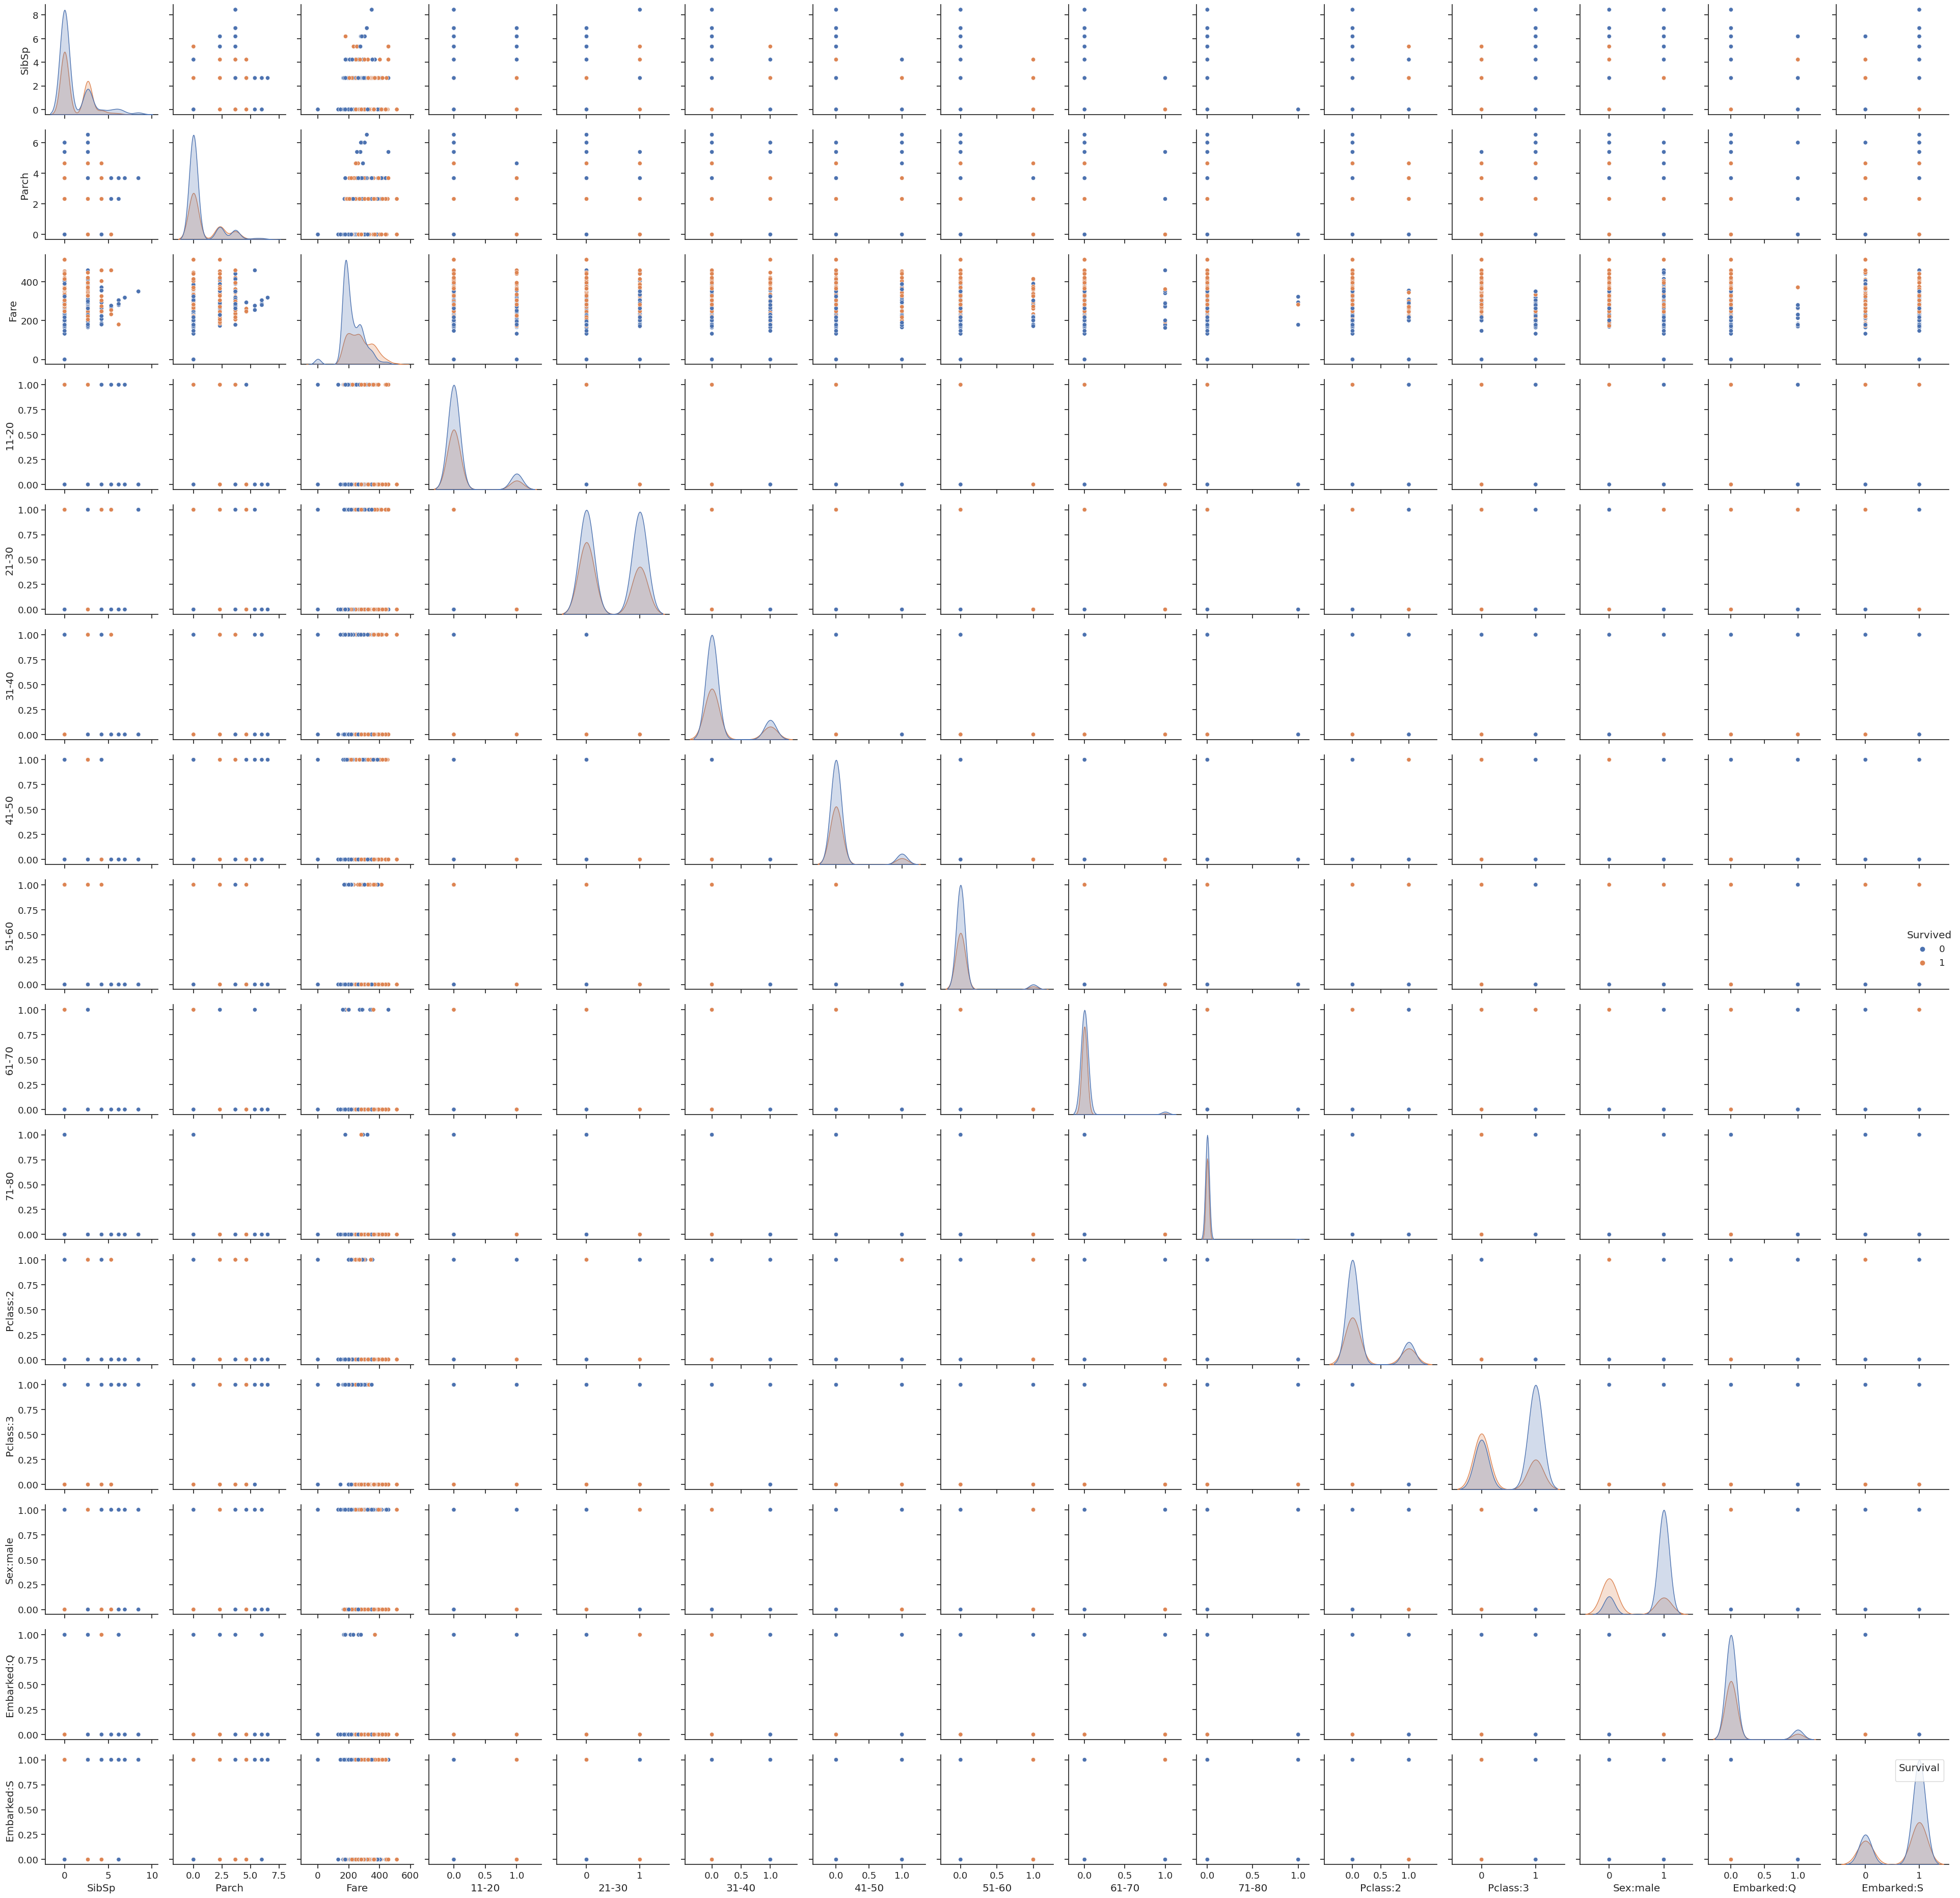

In [82]:
sns.set(style="ticks", font_scale=1.2)
plt.figure(figsize=(12,10))
sns.pairplot(train_df, hue="Survived")
plt.legend(title="Survival", loc="upper right")

plt.tight_layout()
plt.show()

Finally, we checked for outliers. Originally, we tried to create a more general model by replacing the outliers with the closest values within the normal range through the winsorize function, but as a result of testing, it was confirmed that the accuracy before removing the outliers was rather high. It seems that the values that were observed as outliers were probably the values that played a significant role in confirming survival.


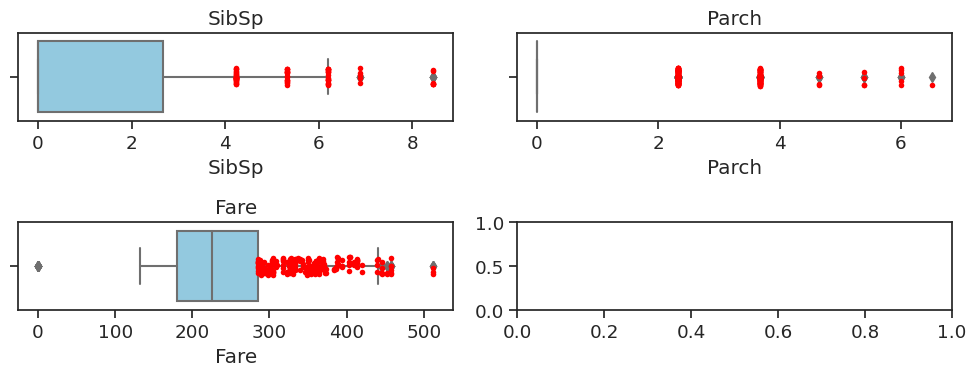

In [83]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 4))
axs = axs.flatten()

for i, col in enumerate(numerical):
    sns.boxplot(x=train_df[col], ax=axs[i], color='skyblue')
    sns.stripplot(x=train_df[col][train_df[col] > train_df[col].quantile(0.75)], ax=axs[i], color='red', size=4)
    axs[i].set_title(col)

fig.tight_layout()
plt.show()

In [218]:
train_win=train_df.copy()

for col in numerical:
  train_win[col] = winsorize(train_win[col], (0.05, 0.05))
train_win.head()

,Survived,SibSp,Parch,Fare,11-20,21-30,31-40,41-50,51-60,61-70,71-80,Pclass:2,Pclass:3,Sex:male,Embarked:Q,Embarked:S
0,0,2.666667,0.0,173.285702,0,1,0,0,0,0,0,0,1,1,0,1
1,1,2.666667,0.0,351.512151,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0.000000,0.0,179.743689,0,1,0,0,0,0,0,0,1,0,0,1
3,1,2.666667,0.0,327.717835,0,0,1,0,0,0,0,0,0,0,0,1
4,0,0.000000,0.0,180.885816,0,0,1,0,0,0,0,0,1,1,0,1


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4650: UserWarning:


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4650: UserWarning:


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4650: UserWarning:




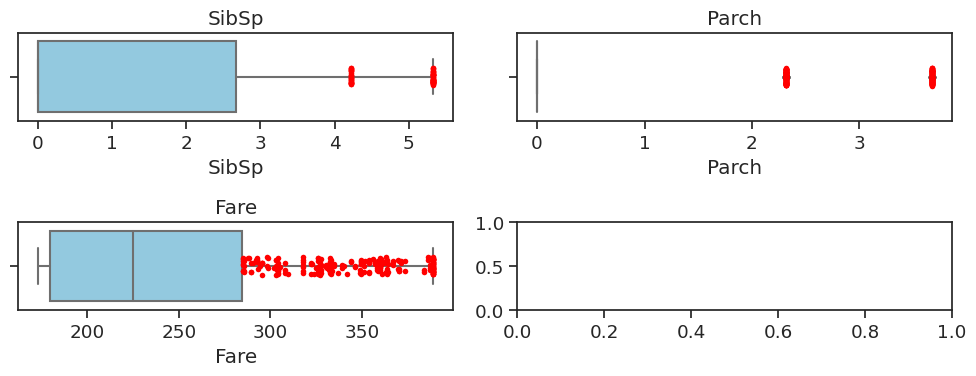

In [88]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 4))
axs = axs.flatten()

for i, col in enumerate(numerical):
    sns.boxplot(x=train_win[col], ax=axs[i], color='skyblue')
    sns.stripplot(x=train_win[col][train_win[col] > train_win[col].quantile(0.75)], ax=axs[i], color='red', size=4)
    axs[i].set_title(col)

fig.tight_layout()
plt.show()

**Make Model**

To determine the model, we will select a number of models and compare their accuracy with GridSearchCV to select the model with the highest accuracy. Since this is a binary classification problem, we trained 5 models of logistic regression, xgb, gradient boosting, decision tree, and knn and compared their accuracy.

In the case of regression, overfitting may occur if there are too many features, so we also considered reducing the features using the SelectKBest function. However, as a result of the test, the accuracy decreased slightly, so it was not used.

In [10]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
'''
selector=SelectKBest(score_func=chi2)
selected=selector.fit_transform(X, y)
selects=list(X.columns[selector.get_support()])
X=X[selects]
'''
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [328]:
models = [
  {
    "name": "Logistic Regression",
    "estimator": LogisticRegression(),
    "hyperparameters": {
      'C': [0.1, 0.5],
        'penalty': ['l1','l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 500]
    }
  },
  {
    "name": "xgb",
    "estimator":  XGBClassifier(),
    "hyperparameters" : {
      'seed': [21],
      'objective': ['binary:logistic'],
      'eval_metric': ['auc']  
    }
  },
  {
    "name": "Gradient Boosting",
    "estimator": GradientBoostingClassifier(),
    "hyperparameters": {
      'learning_rate': [0.05, 0.1],
      'n_estimators': [ 50],
      'max_depth': [3],
      'min_samples_split': [ 5],
      'min_samples_leaf': [ 4],
      'max_features': ['log2']
    }
  },
  {
    "name": "Decision Tree",
    "estimator": DecisionTreeClassifier(),
    "hyperparameters": {
      "criterion": ["gini", "entropy"],
      "max_depth": [3, 5, 10],
      "min_samples_split": [2, 5, 10],
      "min_samples_leaf": [1, 2, 4]
    }
  },
  {
    "name": "K-Nearest Neighbors",
    "estimator": KNeighborsClassifier(),
    "hyperparameters": {
      "n_neighbors": [3, 5, 7],
      "weights": ["distance"],
      "algorithm": ["brute"]
    }
  },
]

In [329]:
accuracies = []
train_accuracies = []
best_models = {}

for model in models:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(f"Training {model['name']}...")
        grid_search = GridSearchCV(
            estimator=model['estimator'],
            param_grid=model['hyperparameters'],
            scoring='accuracy',
            cv=50
        )
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_valid)
        
        accuracy = accuracy_score(y_valid, y_pred)
        confusion = confusion_matrix(y_valid, y_pred)
        roc_auc = roc_auc_score(y_valid, y_pred)

        roc_auc = roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:, 1])

        print(f'Best hyperparameters: {grid_search.best_params_}')
        print("\033[1m--------------------------------------------------------\033[0m")
        print(f'Accuracy: {accuracy}')
        print("\033[1m--------------------------------------------------------\033[0m")
        print(f'ROC AUC score: {roc_auc}')       
        print("\033[1m--------------------------------------------------------\033[0m")
        print(f"Classification report for {model['name']}:")
        print(classification_report(y_valid, y_pred))

        best_models[model['name']] = best_model

Training Logistic Regression...
Best hyperparameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
--------------------------------------------------------
Accuracy: 0.8044692737430168
--------------------------------------------------------
ROC AUC score: 0.8476833976833976
--------------------------------------------------------
Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84       105
           1       0.82      0.68      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.80      0.80       179

Training xgb...
Best hyperparameters: {'eval_metric': 'auc', 'objective': 'binary:logistic', 'seed': 21}
--------------------------------------------------------
Accuracy: 0.7877094972067039
--------------------------------------------------------
ROC AUC score: 0.87136

The results of testing the model are as follows. There is a big difference between using the ROC AUC as the standard and the Accuracy as the standard. The logistic regression model has the lowest ROC AUC score, but has the second highest accuracy. On the contrary, Gradient Bootsting has the highest ROC AUC score, but the lowest accuracy. Therefore, the KNN model that obtained high values in both criteria was selected as the final model.

In [337]:
data = {'Model': [model['name'] for model in models],
        'ROC AUC Score': [roc_auc_score(y_valid, best_models[model['name']].predict_proba(X_valid)[:, 1]) for model in models],
        'Hyperparameters Tested': [len(model['hyperparameters']) for model in models]}
df = pd.DataFrame(data)

fig = px.scatter(df, x='ROC AUC Score', y='Hyperparameters Tested', size='Hyperparameters Tested', color='Model', hover_name='Model', opacity=0.8)

fig.update_layout(
    title='Model Comparison',
    xaxis_title='ROC AUC Score',
    yaxis_title='Number of Hyperparameters Tested',
    legend_title=None
)

pio.show(fig)

In [338]:
data = {
    'Model': [model['name'] for model in models],
    'Accuracy Score': [
        accuracy_score(
            y_valid,
            best_models[model['name']].predict_proba(X_valid)[:, 1] > 0.5
        ) for model in models
    ],
    'Hyperparameters Tested': [len(model['hyperparameters']) for model in models]
}
df = pd.DataFrame(data)

fig = px.scatter(
    df,
    x='Accuracy Score',
    y='Hyperparameters Tested',
    size='Hyperparameters Tested',
    color='Model',
    hover_name='Model',
    opacity=0.8
)

fig.update_layout(
    title='Model Comparison',
    xaxis_title='Accuracy Score',
    yaxis_title='Number of Hyperparameters Tested',
    legend_title=None
)

pio.show(fig)

In [11]:
knn=KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='brute')

knn.fit(X_train, y_train)

print("accuracy:", knn.score(X_valid, y_valid))

accuracy: 0.8268156424581006


In [12]:
#preprocessing
X_test=test_df.drop(columns=drop, axis=1)

X_test.drop(columns='Ticket', axis=1, inplace=True)

for col in X_test.columns:
  if X_test[col].isna().sum()>0:
    X_test[col]=X_test[col].fillna(X_test[col].mode()[0])

df=categorical_age(X_test)
X_test.drop(columns='Age', axis=1, inplace=True)
df.drop(columns='0-10', axis=1, inplace=True)
X_test=pd.concat([X_test, df], axis=1)

#for col in numerical:
#  X_test[col]=np.log(X_test[col]+1)/math.log(max(X_test[col]))*max(X_test[col])

for col in numerical:
  X_test[col]=(X_test[col]-min(X_test[col]))/(max(X_test[col])-min(X_test[col]))

#for col in numerical:
#  X_test[col] = winsorize(X_test[col], (0.05, 0.05))

for col in ['Pclass', 'Sex', 'Embarked']:
  test_dummies=pd.get_dummies(X_test[col], drop_first=True)
  test_dummies.columns=[col+":"+str(test_dummies.columns[i]) for i in range(len(test_dummies.columns))]
  X_test.drop(columns=col, axis=1, inplace=True)
  X_test=pd.concat([X_test, test_dummies], axis=1)
X_test=X_test.reindex(columns = train_df.drop(columns='Survived', axis=1).columns, fill_value=0)

#model
predict=knn.predict(X_test)

submit=pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predict})

submit.to_csv('submission.csv',index = False)

**Result**

I ended up with a model with an accuracy of 0.78229. This is a score corresponding to 2841st out of 15982 people who completed the same task.

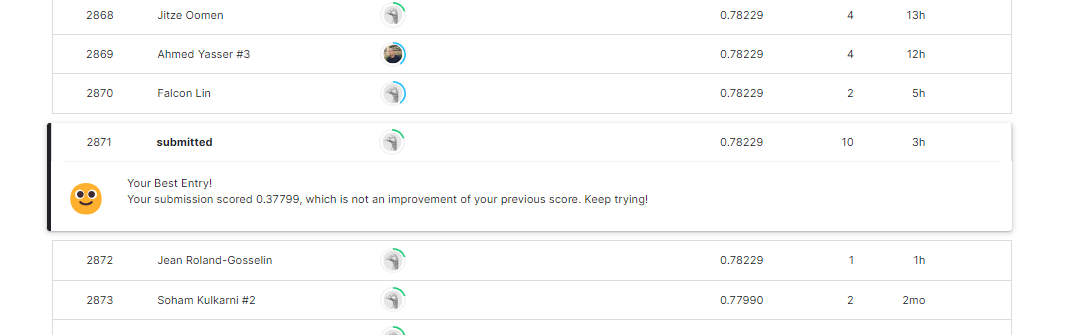

**Feature Analysis**

Since KNN classifies based on other nearby data, it is difficult to determine the importance of each element. Therefore, we will investigate the contribution of each factor using the second most accurate logistic regression model.

In [346]:
lr=LogisticRegression(C=0.1, max_iter=100, penalty='l2', solver='liblinear')
lr.fit(X_train, y_train)
print("accuracy:", lr.score(X_valid, y_valid))

accuracy: 0.8044692737430168


The learned coefficients of each feature are as follows. In terms of absolute value, gender has the greatest influence. For men, the coefficient is -1.7068, indicating that the probability of death is very high. Conversely, women are not affected by the coefficient, so it can be seen that the survival probability is relatively high.

The coefficient of Pclass:3 is -0.8289, which has the second largest absolute value. Considering the fact that the second class room had the fewest survivors in the previous review, this is unusual. Perhaps the death rate was high because the number of people in the third class room was the highest, and as a result of analyzing the trainset, there were actually 491 people in the third class room, which was more than the sum of all other classes, and it was the highest in terms of mortality.

The third element is Fare. In the case of Fare, it is a numerical value. Since the numerical values are collectively normalized, all values are less than 1, and accordingly, the coefficient to be multiplied is likely to be larger than the categorical value. Therefore, there is a possibility that the actual role of Fare is not large. Fare is easily affected by other factors such as where you board the ship and the quality of the cabin. Therefore, it is difficult to generalize, but it would be correct to interpret that it is basically related to the degree of wealth of the target. Therefore, it can be seen that people with a certain level of economic power are more likely to survive.

In [369]:
coef_df = pd.DataFrame(data=lr.coef_, columns=X_train.columns)
print("bias:", lr.intercept_)
coef_df = coef_df[coef_df.columns[coef_df.iloc[0].argsort()[::-1]]]
coef_df.head()

bias: [1.06459321]


,Fare,31-40,Pclass:2,Embarked:Q,71-80,Parch,51-60,41-50,11-20,61-70,21-30,SibSp,Embarked:S,Pclass:3,Sex:male
0,0.382176,0.215619,0.081427,0.05636,0.052517,0.025265,-0.030387,-0.065748,-0.068209,-0.083501,-0.0898,-0.208154,-0.226125,-0.822886,-1.706834


**Conclusion**

The purpose of this project is to create a model that predicts the survival of occupants in similar maritime accidents through the data of the Titanic incident, and to compare the weights of each feature to find out which characteristics have the most significant effect on survival.


In the project, I removed features that were insignificant or included a large number of null values, and classified the remaining features into numerical and categorical values, normalizing the numerical values, and using one-hot encoding for the categorical values to undergo preprocessing.

In particular, in the case of age, it was expected that it would be difficult to see a linear relationship, so it was used in a categorical form by grouping it into 10-year units.

The most surprising thing about the project was that the techniques commonly used to increase performance resulted in a decrease in accuracy.

In the case of the log scale used to correct the degree of linearity of the numbers, the input value was corrupted and rather lower accuracy was shown.

Even when the outliers were removed, many outliers were replaced with values within the normal range, making it difficult to learn about the outliers, resulting in low accuracy.

Finally, even in the case of SelectKBest, which was executed to reduce the number of features, the accuracy tended to decrease slightly as the learning was not completed perfectly due to the lack of features.

As such, it was confirmed that the techniques for increasing accuracy could rather cause a decrease in accuracy if not used appropriately according to the situation.


As a result of training the model, it was confirmed that the knn model had the highest score when both accuracy and ROC AUC score were considered. The accuracy when using the knn model was about 0.7823, indicating a fairly high accuracy. It can be seen that the simplicity and performance of the model are separate issues in that knn, which classifies through distance, showed higher performance than other complex models.

As a result of comparing the weights using the logistic regression model, which recorded the next highest accuracy, instead of the knn model, which is difficult to analyze, it was confirmed that the three most important factors in survival were, in turn, gender, social position, and fare paid. It was confirmed that the survival probability decreased when the gender was male and when the social position was relatively low, and the survival probability increased in proportion to the fee paid. This shows that gender and economic power had the greatest influence.

As a result, I made a model using knn that can judge the survival of the Titanic accident with an accuracy of 0.7823. In addition, a logistic regression model was used to confirm that the most important factors for survival were gender and economic power. Although, for now, only the Titanic accident has been analyzed, the results can be applied to other similar accidents. If the analysis of other cases is added, it will be possible to identify victims who are relatively difficult to survive in marine accidents, and based on this information, it will be helpful for rescue activities by quickly checking whether all victims have been rescued.